In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

### Preparing Data
We generate 500 random x points and 500 random y points. For education purposes, the line separating "positive" cases from negative cases is $y = x$. We compute the class of each (x, y) point as y > x. Then we separate points by a coridor of width 1. This is done by adding vector $\left(\sqrt{\frac{1}{2}}, -\sqrt{\frac{1}{2}}\right)$ to points in class 0, and adding $\left(-\sqrt{\frac{1}{2}}, \sqrt{\frac{1}{2}}\right)$ to points in class 1.

In [2]:
min_y = min_x = -5
max_y = max_x = 5
x_coords = np.random.uniform(min_x, max_x, (500, 1))
y_coords = np.random.uniform(min_y, max_y, (500, 1))
clazz = np.greater(y_coords, x_coords).astype(int)
delta = 0.5 / np.sqrt(2.0)
x_coords = x_coords + ((0 - clazz) * delta) + ((1 - clazz) * delta)
y_coords = y_coords + (clazz * delta) + ((clazz - 1) * delta)

### Visualizing data

Let us quickly see what we have created. We have a set of 500 points. A set of points above $y = x$ line is classified as belonging to class 1 (positive cases) and the set of points below $y = x$ belongs to class 0.

In [3]:
%matplotlib inline

def PlotClasses(span, delta, x, y, clazz, annotations=None):
  fig, ax = plt.subplots(figsize=(8, 8))
  ax.scatter(x, y, c=clazz, cmap=cm.coolwarm)
  ax.plot(span, 1 * span + 0, 'k-')
  ax.plot(span, 1 * span + delta, 'k,')
  ax.plot(span, 1 * span - delta, 'k,')
  if annotations:
    for i, txt in enumerate(annotations):
      ax.annotate(txt, (x[i], y[i]))
  plt.show()  

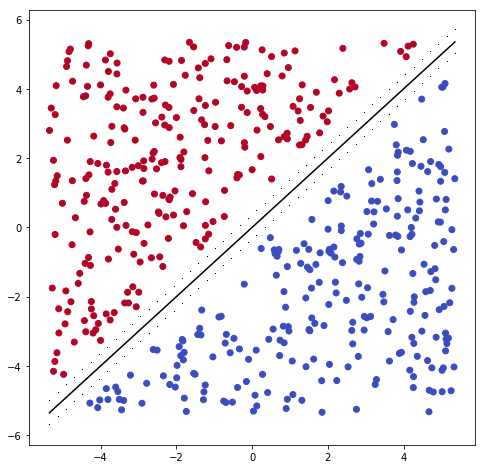

In [4]:
x_range = np.linspace(min_x - delta, max_x + delta)
PlotClasses(x_range, delta, x_coords, y_coords, clazz)

### Input Function

The job of the input function is to feed data into SVM. It is common to all contributed Estimator classes. In case of SVM we need to provide a column that specifies the ID for each training data, and one or more vectors that return coordinates of points that we train SVM to separate. In our trivial examples (which makes it easy to visualize it) we use points on a 2D plane. In a more complex applications you could have a much higher dimentionality data. 

In [5]:
def input_fn():
  """
  The function provided input for the SVM training.
  
  In real life code this function would probably read batches of data and return
  batches of IDs and feature columns. For us we simply generate all IDs in one
  go, and create both feature columns by reshaping x_coords and y_coords into
  a n x 1 vectors.
  """
  return {
      'example_id': tf.constant(map(lambda x: str(x + 1), np.arange(len(x_coords)))),
      'x': tf.constant(np.reshape(x_coords, [x_coords.shape[0], 1])),
      'y': tf.constant(np.reshape(y_coords, [y_coords.shape[0], 1])),
  }, tf.constant(clazz)

### Training SVM

To train SVM we need to inform it which elements of the dictionary returned by `input_fn` are features and which are labels. We create two, 1D features of real values called `x` and `y`. We have one 1D tensor that holds string labels for our examples. In our case all examples are returned at once. However, in real applications you could create a function that reads data from a file or a server and returns batches. It could also return same batches repeatedly, in which case `example_id` should reflect this. When calling the `fit` method of the estimator we also specify the number of `steps` it should run. Alternatively, we could specify `max_steps` to run. With `steps`, every time we call `fit` method, it runs the given number of steps. With `max_steps`, once the estimator was run for that number of steps any subsequent calls to `fit` exit immediately, without performing any further fitting of data.

In [6]:
# Contrib libraries seem overly verbose. Only output errors.
tf.logging.set_verbosity(tf.logging.ERROR)

feature1 = tf.contrib.layers.real_valued_column('x')
feature2 = tf.contrib.layers.real_valued_column('y')
svm_classifier = tf.contrib.learn.SVM(
  feature_columns=[feature1, feature2],
  example_id_column='example_id')
svm_classifier.fit(input_fn=input_fn, steps=30)
metrics = svm_classifier.evaluate(input_fn=input_fn, steps=1)
print "Loss", metrics['loss'], "\nAccuracy", metrics['accuracy']

Loss 0.00118758 
Accuracy 1.0


### Predicting lables

Once SVM classifier has been trained, we can use it to predict classes for n-dimentional (2 in our case) points. We create another function, `predict_fn` that returns some data that we wish SVM to classify. We run `predict` method that returns an iterable of dictionaries. Each dictionary holds two elements: `classes` and `logits`. The first one gives us the classes to which the given example belongs. The second one can be used to estimate the probability of those classes. For example, for our trivially seprable example a point $(-0.27510791, -0.4940773)$ has class 0, and logits $-0.28906667$. On the other hand $(3.39027299, -2.13721821)$, which also belongs to class 0, has logits $-7.00896215$.

In [7]:
x_predict = np.random.uniform(min_x, max_x, (20, 1))
y_predict = np.random.uniform(min_y, max_y, (20, 1))

def predict_fn():
  return {
    'x': tf.constant(x_predict),
    'y': tf.constant(y_predict),
  }

pred = list(svm_classifier.predict(input_fn=predict_fn))
predicted_class = map(lambda x: x['classes'], pred)
annotations = map(lambda x: '%.2f' % x['logits'][0], pred)

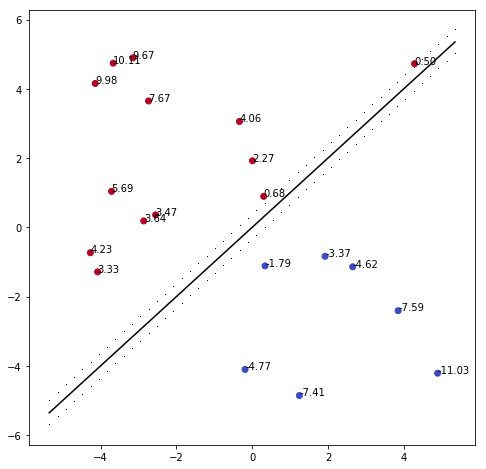

In [8]:
PlotClasses(x_range, delta, x_predict, y_predict, predicted_class, annotations)